Импорт библиотек

In [2]:
import sys
import os
import cv2
import time
import tqdm
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch


import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

import albumentations as albu
from albumentations.pytorch import ToTensorV2

from catalyst.contrib.data import transforms
from catalyst.contrib.data.reader import ScalarReader, ReaderCompose, LambdaReader
from catalyst.contrib.data.reader_cv import ImageReader
from catalyst.runners import SupervisedRunner
from catalyst.dl import DiceCallback, EarlyStoppingCallback, CheckpointCallback, SchedulerCallback
from catalyst.contrib.models.resnet_encoder import ResnetEncoder
import segmentation_models_pytorch as smp

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.deterministic = True

Открытие датасета

In [3]:
train = pd.read_csv('train.csv')
sub = pd.read_csv('sample_submission.csv')
train.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [4]:
n_train = len(os.listdir('train_images'))
n_test = len(os.listdir('test_images'))
print(f'Number of train images: {n_train}')
print(f'Number of test images: {n_test}')

Number of train images: 12568
Number of test images: 5506


In [6]:
train['EncodedPixels'].isnull().any()

False

Функции для визуализации

In [7]:
def rle_decode(mask_rle: str = '', shape: tuple = (256, 1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (256, 1600)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['ImageId'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask

    return masks

def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Class 1', 1: 'Class 2', 2: 'Class 3', 3: 'Class 4'}
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 2, figsize=(24, 24))

        ax[0].imshow(image)
        ax[1].imshow(mask[:,:,i])
    else:
        f, ax = plt.subplots(2, 2, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        #ax[0, 0].set_title('Original image', fontsize=fontsize)


        ax[0,  1].imshow(original_mask[:, :, i])
            #ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)

        ax[1, 0].imshow(image)
        #ax[1, 0].set_title('Transformed image', fontsize=fontsize)


        ax[1,  1].imshow(mask[:, :, i])
            #ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')
def plot_with_augmentation(image, mask, augment):
  augmented = augment(image=image, mask=mask)
  image_flipped = augmented['image']
  mask_flipped = augmented['mask']
  visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(256, 1600),
        albu.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 1600),
        albu.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Визуализация данных

0 (0, ImageId                                              0002cc93b.jpg
ClassId                                                          1
EncodedPixels    29102 12 29346 24 29602 24 29858 24 30114 24 3...
Name: 0, dtype: object)
1 (1, ImageId                                              0007a71bf.jpg
ClassId                                                          3
EncodedPixels    18661 28 18863 82 19091 110 19347 110 19603 11...
Name: 1, dtype: object)
2 (2, ImageId                                              000a4bcdd.jpg
ClassId                                                          1
EncodedPixels    37607 3 37858 8 38108 14 38359 20 38610 25 388...
Name: 2, dtype: object)
3 (3, ImageId                                              000f6bf48.jpg
ClassId                                                          4
EncodedPixels    131973 1 132228 4 132483 6 132738 8 132993 11 ...
Name: 3, dtype: object)


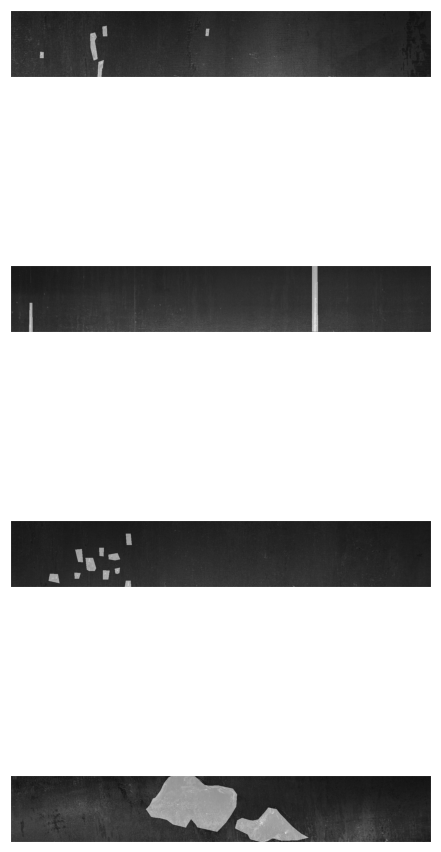

In [8]:
from PIL import Image
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(train['ImageId'][:4]):
    for i, (idx, row) in enumerate(train.loc[train['ImageId'] == im_id].iterrows()):
        print(j, (idx, row))
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"train_images/{row['ImageId']}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        mask = rle_decode(mask_rle)
        plt.imshow(mask, alpha=0.5, cmap='gray')

In [9]:
image_name = '000f6bf48.jpg'
image = get_img(image_name)
mask = make_mask(train, image_name)

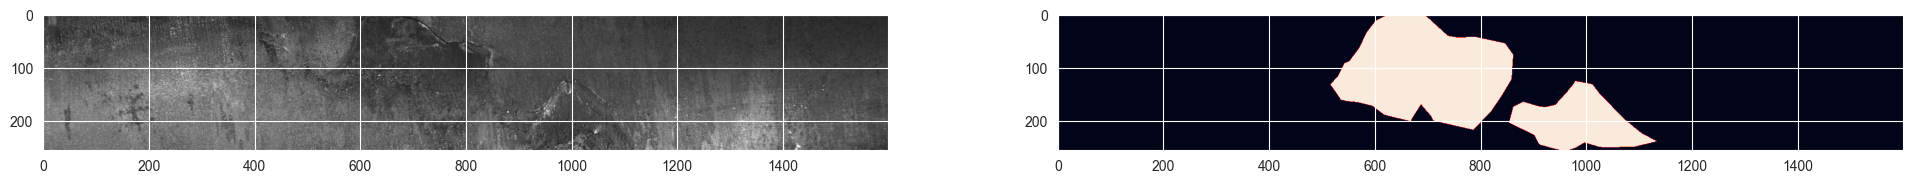

In [10]:
visualize(image, mask)

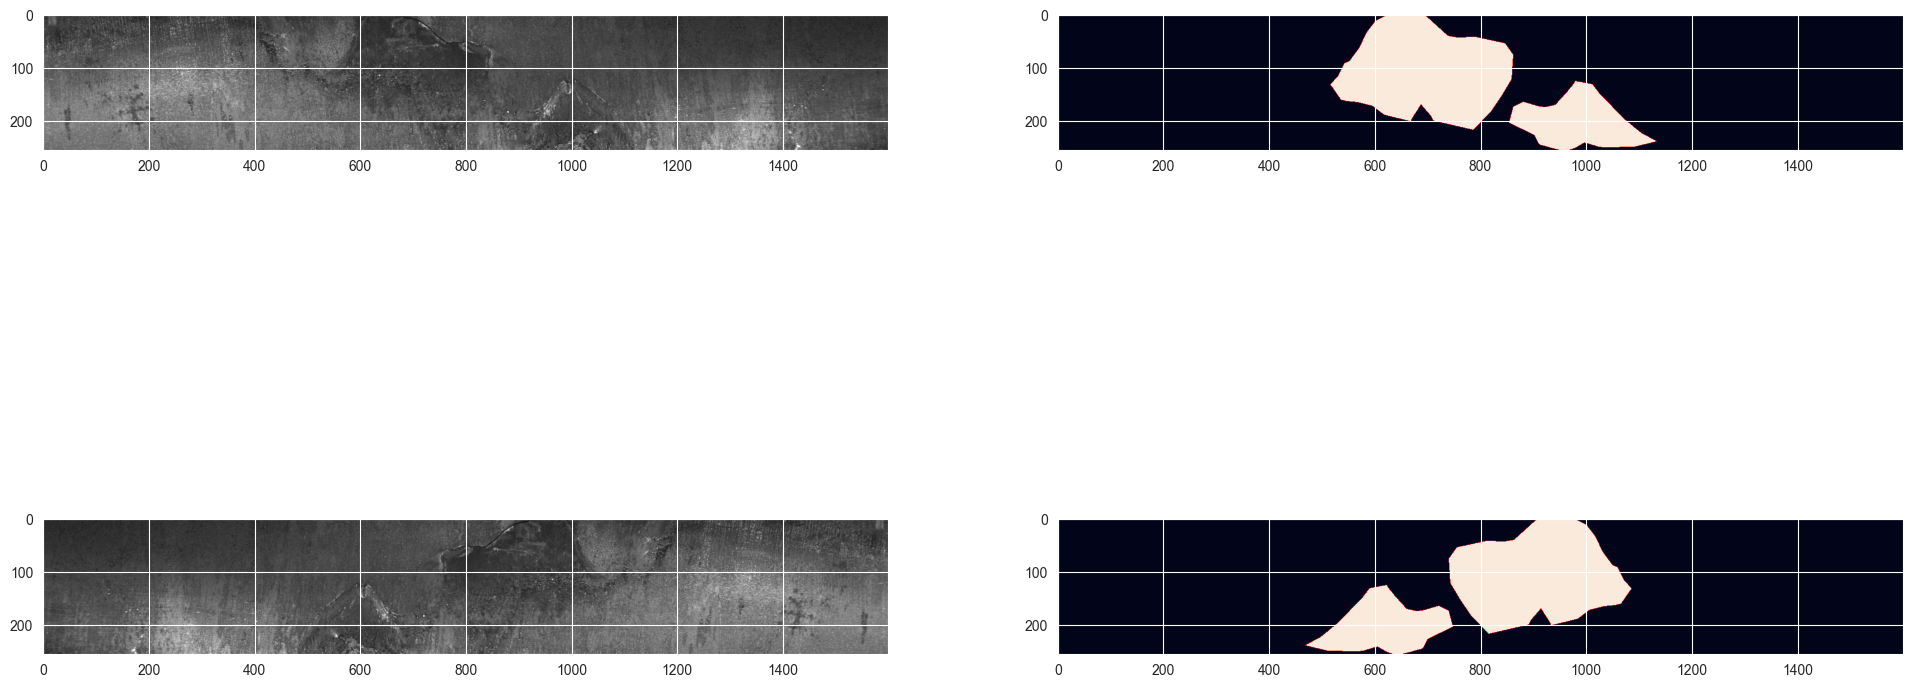

In [11]:
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

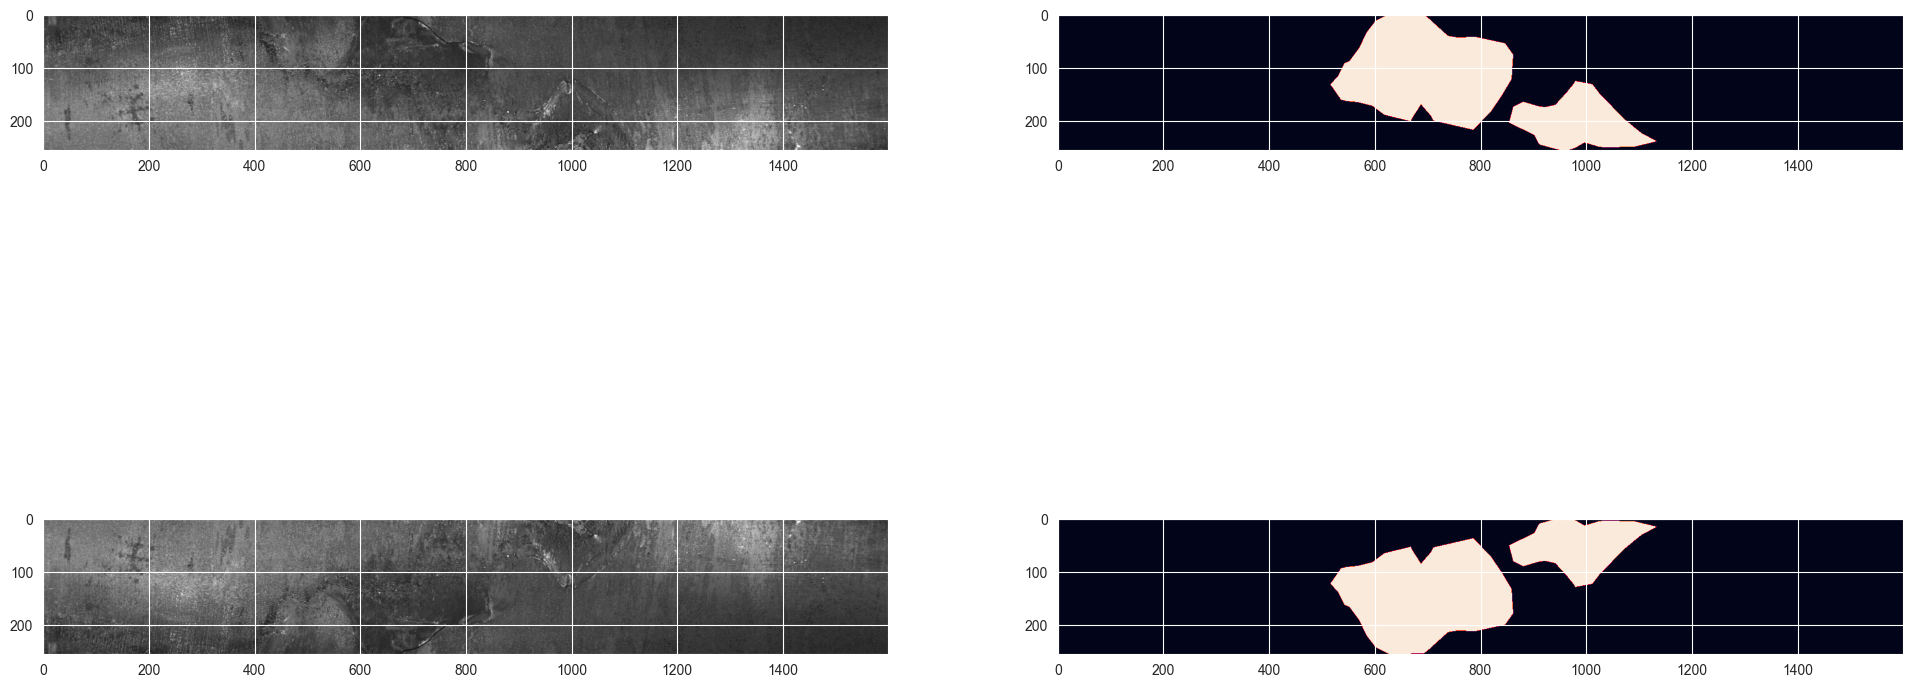

In [12]:
plot_with_augmentation(image, mask, albu.VerticalFlip(p=1))

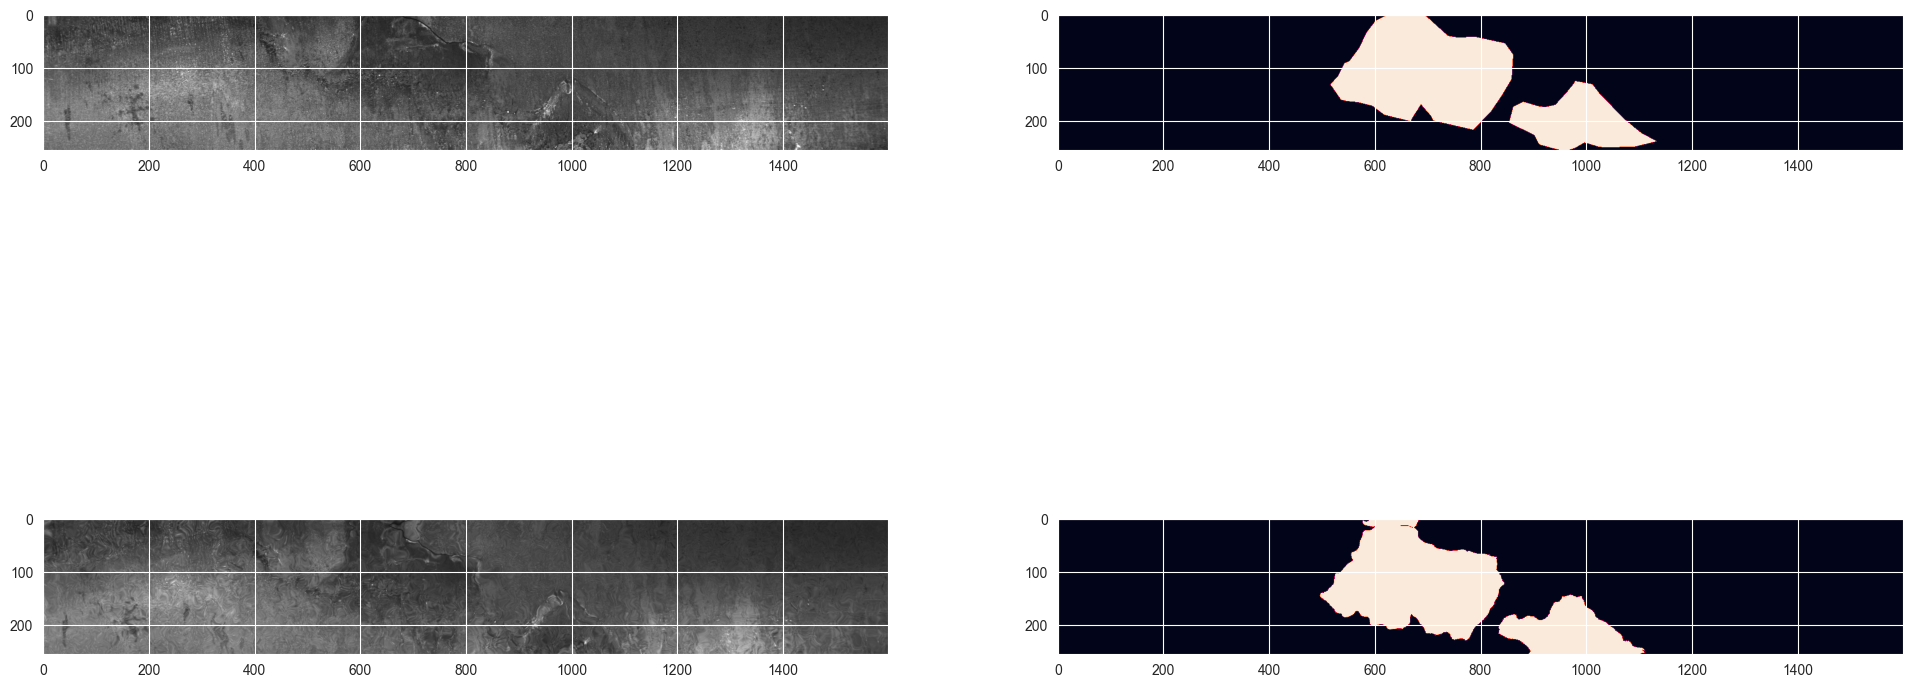

In [13]:
plot_with_augmentation(image, mask, albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03))

In [17]:
id_mask_counts = train.loc[train['EncodedPixels'].isnull()==False, 'ImageId'].value_counts().\
reset_index().rename(columns={'index': 'ImageId', 'ImageId': 'count'})
train_ids, valid_ids = train_test_split(id_mask_counts['ImageId'].values, random_state=seed, stratify = id_mask_counts['count'], test_size=0.1)
test_ids = sub['ImageId'].drop_duplicates().values
# print(id_mask_counts)
# print(train['ImageId'])

Подготовка датасета

In [18]:
class steel_defection(Dataset):
  def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', transform=None, img_ids: np.array = None, transforms = albu.Compose([albu.HorizontalFlip(), ToTensorV2()]), preprocessing=None):
    self.df = df
    if datatype != 'test':
      self.data_folder = "train_images"
    else:
      self.data_folder = "test_images"
    self.img_ids = img_ids
    self.transforms = transforms
    self.preprocessing = preprocessing

  def __getitem__(self, idx):
    image_name = self.img_ids[idx]
    mask = make_mask(self.df, image_name)
    image_path = os.path.join(self.data_folder, image_name)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = self.transforms(image=img, mask=mask)
    if self.preprocessing:
      preprocessed = self.preprocessing(image=img, mask=mask)
      img = preprocessed['image']
      mask = preprocessed['mask']
    return img, mask

  def __len__(self):
      return len(self.img_ids)

Пренатренерованная модель

In [15]:
import segmentation_models_pytorch as smp
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=4,
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Mego4el/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Подготовка к тренеровки

In [19]:
num_workers = 4
bs = 1
train_dataset = steel_defection(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing = get_preprocessing(preprocessing_fn))
valid_dataset = steel_defection(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing = get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)
loaders = {"train": train_loader, "valid": valid_loader}

In [20]:
from catalyst.contrib.losses import IoULoss
num_epochs = 0
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
#criterion = smp.losses.DiceLoss(mode='multilabel')
criterion = IoULoss()
runner = SupervisedRunner( input_key="features", output_key="scores", target_key="targets", loss_key="loss")

Тренеровка

In [22]:
from catalyst import dl
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    scheduler=ReduceLROnPlateau(optimizer, factor=0.15, patience=2),
    callbacks=[
        dl.IOUCallback(input_key="scores", target_key="targets"),
        dl.DiceCallback(input_key="scores", target_key="targets"),
        #dl.TrevskyCallback(input_key="scores", target_key="targets", alpha=0.2),
    ],
    logdir = logdir,
    num_epochs = num_epochs,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=False,
    verbose=True,
)

Top models:

